# Variational Autoencoder

- Bernoulli and Gaussian versions

## References

- Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114
- Building Autoencoders in Keras http://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import range

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.set_random_seed(0)

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Lambda
from keras.objectives import binary_crossentropy
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

import matplotlib.pyplot as plt

Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.3376 - val_loss: 0.2484
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.2448 - val_loss: 0.2363
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.2339 - val_loss: 0.2298
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.2290 - val_loss: 0.2260
Epoch 5/10
60000/60000 [==============================] - 3s - loss: 0.2258 - val_loss: 0.2234
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.2218 - val_loss: 0.2186
Epoch 7/10
60000/60000 [==============================] - 3s - loss: 0.2179 - val_loss: 0.2152
Epoch 8/10
60000/60000 [==============================] - 3s - loss: 0.2141 - val_loss: 0.2120
Epoch 9/10
60000/60000 [==============================] - 3s - loss: 0.2104 - val_loss: 0.2094
Epoch 10/10
60000/60000 [==============================] - 3s - loss: 0.2080 - val_loss: 0.2060

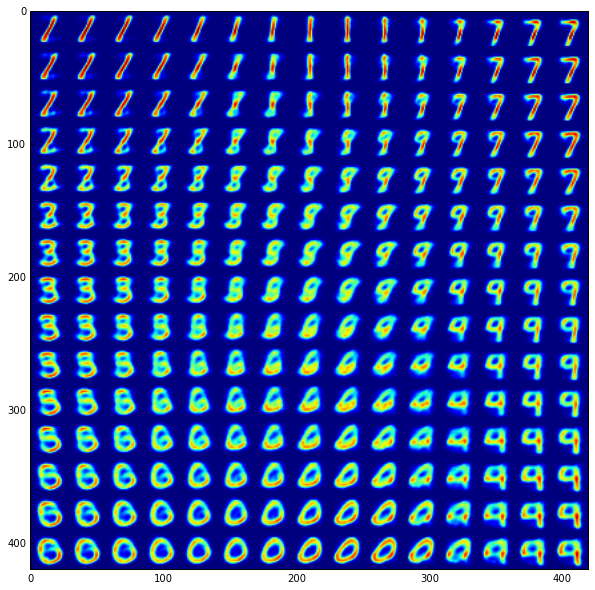

In [2]:
def bernoulli_vae(batch_size, x_dim, z_dim, nb_units):
    inputs = Input(shape=(x_dim,))
    
    enc_nn = [Dense(nb_units, activation="tanh"),
              Dense(nb_units, activation="tanh")]
    
    for i, enc in enumerate(enc_nn):
        if i == 0:
            x = enc(inputs)
        else:
            x = enc(x)
            
    mean_enc = Dense(z_dim)
    log_var_enc = Dense(z_dim)
    
    z_mean = mean_enc(x)
    z_log_var = log_var_enc(x)
    
    def sample(z_mean, z_log_var):
        eps = K.random_normal((tf.shape(inputs)[0], z_dim), mean=0.0, std=0.01)
        return tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_log_var)), eps))
    z = Lambda(lambda x: sample(x[0], x[1]), output_shape=(z_dim,))([z_mean, z_log_var])
    
    dec_nn = [Dense(nb_units, activation="tanh"),
              Dense(nb_units, activation="tanh")]
    
    for i, dec in enumerate(dec_nn):
        if i == 0:
            x = dec(z)
        else:
            x = dec(x)

    mean_dec = Dense(x_dim, activation="sigmoid")
    recon_mean = mean_dec(x)
    
    def loss(y_true, y_pred):
        recon_loss = binary_crossentropy(y_true, y_pred)
        kld = 0.5 * K.mean(1 + z_log_var -
                           K.square(z_mean) -
                           K.exp(z_log_var), axis=-1)
        return recon_loss - kld
    
    model = Model(inputs, recon_mean)
    model.compile(optimizer="adam", loss=loss)
    
    encoder = Model(inputs, z_mean)
    
    dec_inputs = Input(shape=(z_dim,))
    for i, dec in enumerate(dec_nn):
        if i == 0:
            x = dec(dec_inputs)
        else:
            x = dec(x)
    recon_mean = mean_dec(x)
    decoder = Model(dec_inputs, recon_mean)
    
    return model, encoder, decoder
    

# train the VAE on MNIST digits
(X_train, _), (X_test, _) = mnist.load_data()

X_train = np.asarray(X_train, dtype=np.float32) / 255.
X_test = np.asarray(X_test, dtype=np.float32) / 255.
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))

model, encoder, decoder = bernoulli_vae(batch_size=200,
                                        x_dim=28 * 28,
                                        z_dim=2,
                                        nb_units=512)
model.fit(X_train, X_train,
          shuffle=True,
          nb_epoch=10,
          batch_size=200,
          validation_data=(X_test, X_test),
          verbose=1)

n = 15
img_size = 28
manifold = np.zeros((img_size * n, img_size * n))
z1 = np.linspace(-15, 15, n)
z2 = np.linspace(-15, 15, n)

for i, y in enumerate(z1):
    for j, x in enumerate(z2):
        z_sample = np.array([[x, y]]) * 0.01
        decoded = decoder.predict(z_sample)
        manifold[i * img_size: (i + 1) * img_size,
                 j * img_size: (j + 1) * img_size] = decoded[0].reshape(img_size, img_size)

plt.figure(figsize=(10, 10))
plt.imshow(manifold)
plt.show()

# Gaussian posterior

- It might be improper to use gaussian distribution as posterior for MNIST

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.3278 - val_loss: 0.2483
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.2434 - val_loss: 0.2353
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.2328 - val_loss: 0.2288
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.2283 - val_loss: 0.2265
Epoch 5/10
60000/60000 [==============================] - 3s - loss: 0.2250 - val_loss: 0.2227
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.2212 - val_loss: 0.2173
Epoch 7/10
60000/60000 [==============================] - 3s - loss: 0.2169 - val_loss: 0.2143
Epoch 8/10
60000/60000 [==============================] - 3s - loss: 0.2132 - val_loss: 0.2104
Epoch 9/10
60000/60000 [==============================] - 3s - loss: 0.2102 - val_loss: 0.2094
Epoch 10/10
60000/60000 [==============================] - 3s - loss: 0.2079 - val_loss: 0.2065

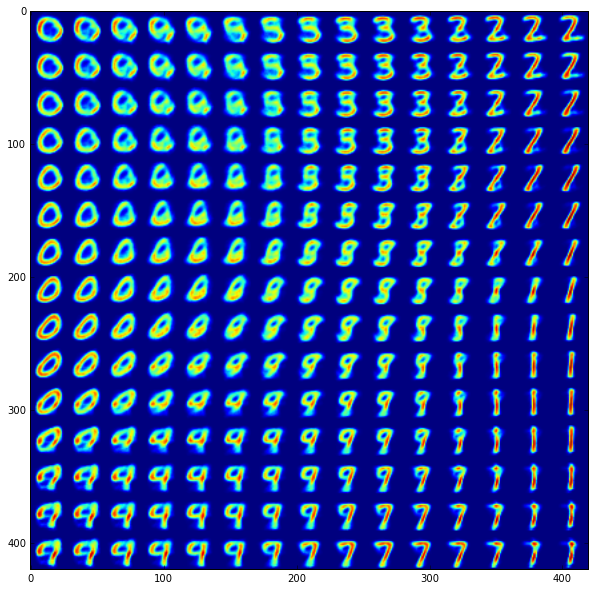

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist


def gaussian_vae(batch_size, x_dim, z_dim, nb_units):
    inputs = Input(shape=(x_dim,))
    
    enc_nn = [Dense(nb_units, activation="tanh"),
              Dense(nb_units, activation="tanh")]
    
    for i, enc in enumerate(enc_nn):
        if i == 0:
            x = enc(inputs)
        else:
            x = enc(x)
            
    mean_enc = Dense(z_dim)
    log_var_enc = Dense(z_dim)
    
    z_mean = mean_enc(x)
    z_log_var = log_var_enc(x)
    
    def sample(z_mean, z_log_var):
        eps = K.random_normal((tf.shape(inputs)[0], z_dim), mean=0.0, std=0.01)
        return tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_log_var)), eps))
    z = Lambda(lambda x: sample(x[0], x[1]), output_shape=(z_dim,))([z_mean, z_log_var])
    
    dec_nn = [Dense(nb_units, activation="tanh"),
              Dense(nb_units, activation="tanh")]
    
    for i, dec in enumerate(dec_nn):
        if i == 0:
            x = dec(z)
        else:
            x = dec(x)

    mean_dec = Dense(x_dim)
    log_sigma_dec = Dense(x_dim)
    recon_mean = mean_dec(x)
    recon_log_sigma = log_sigma_dec(x)
    
    def loss(y_true, y_pred):
        recon_loss = -0.5 * K.mean(K.log(2 * np.pi) + recon_log_sigma +
                                   K.square(y_true - y_pred) / K.exp(recon_log_sigma), axis=-1)
        kld = 0.5 * K.mean(1 + z_log_var -
                           K.square(z_mean) -
                           K.exp(z_log_var), axis=-1)
        return recon_loss - kld
    
    model = Model(inputs, recon_mean)
    model.compile(optimizer="adam", loss=loss)
    
    encoder = Model(inputs, z_mean)
    
    dec_inputs = Input(shape=(z_dim,))
    for i, dec in enumerate(dec_nn):
        if i == 0:
            x = dec(dec_inputs)
        else:
            x = dec(x)
    recon_mean = mean_dec(x)
    recon_log_sigma = log_sigma_dec(x)
    decoder = Model(dec_inputs, recon_mean)
    
    return model, encoder, decoder
    

# train the VAE on MNIST digits
(X_train, _), (X_test, _) = mnist.load_data()

X_train = np.asarray(X_train, dtype=np.float32) / 255.
X_test = np.asarray(X_test, dtype=np.float32) / 255.
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_test = X_test.reshape((X_test.shape[0], 28 * 28))

model, encoder, decoder = bernoulli_vae(batch_size=200,
                                        x_dim=28 * 28,
                                        z_dim=2,
                                        nb_units=512)
model.fit(X_train, X_train,
          shuffle=True,
          nb_epoch=10,
          batch_size=200,
          validation_data=(X_test, X_test),
          verbose=1)

n = 15
img_size = 28
manifold = np.zeros((img_size * n, img_size * n))
z1 = np.linspace(-15, 15, n)
z2 = np.linspace(-15, 15, n)

for i, y in enumerate(z1):
    for j, x in enumerate(z2):
        z_sample = np.array([[x, y]]) * 0.01
        decoded = decoder.predict(z_sample)
        manifold[i * img_size: (i + 1) * img_size,
                 j * img_size: (j + 1) * img_size] = decoded[0].reshape(img_size, img_size)

plt.figure(figsize=(10, 10))
plt.imshow(manifold)
plt.show()